In [1]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

In [3]:
def clear_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'[^ a-z]', '', text)
    while text.find('  ') != -1:
        text = text.replace('  ', ' ')
    return text

In [4]:
data_train['clean_text']= data_train['Text'].apply(lambda x:clear_text(x))
data_test['clean_text']= data_test['Text'].apply(lambda x:clear_text(x))

In [5]:
data_train['clean_text'] = data_train['clean_text'].apply(lambda x:word_tokenize(x))
data_test['clean_text'] = data_test['clean_text'].apply(lambda x:word_tokenize(x))

In [6]:
def remove_stop_words(text):
    stop_words = stopwords.words('english')
    filtered_text = []
    for w in text:
        if w not in stop_words:
            filtered_text.append(w)
    return filtered_text

In [7]:
data_train['clean_text'] = data_train['clean_text'].apply(lambda x:remove_stop_words(x))
data_test['clean_text'] = data_test['clean_text'].apply(lambda x:remove_stop_words(x))

In [8]:
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatizer(text):
    return [wordnet_lemmatizer.lemmatize(w) for w in text]

data_train['clean_text'] = data_train['clean_text'].apply(lambda x:lemmatizer(x))
data_test['clean_text'] = data_test['clean_text'].apply(lambda x:lemmatizer(x))

In [9]:
def to_text(data):
    text = []
    for i in data:
        for word in i:
            text.append(word)
    return text

text = to_text(data_train['clean_text'])
text += to_text(data_test['clean_text'])
text.sort()
dictionary = []
for i in text:
    if i not in dictionary:
        dictionary.append(i)


In [10]:
def convert_to_numbers(text):
    res = []
    for word in text:
        res.append(dictionary.index(word))
    return res

def convert_to_text(numbers):
    res = []
    for num in numbers:
        res.append(dictionary[num])
    return res

In [11]:
data_train['numbers'] = data_train['clean_text'].apply(lambda x:convert_to_numbers(x))
data_test['numbers'] = data_test['clean_text'].apply(lambda x:convert_to_numbers(x))


In [12]:
#good: happy, love, surprise
#bad: sadness, anger, fear

def t_or_f(emotion):
    if emotion == 'happy' or emotion == 'love' or emotion == 'surprise':
        return 1        
    else:        #elif emotioin == 'sadness' or 'anger' or 'fear': return 0
        return 0
    
data_train['Emotion_in_digit'] = data_train['Emotion'].apply(lambda x:t_or_f(x))
data_test['Emotion_in_digit'] = data_test['Emotion'].apply(lambda x:t_or_f(x))

# data_train[['Emotion','Emotion_in_digit']]

In [13]:
data_train = data_train[['Emotion_in_digit', 'numbers']]
data_test = data_test[['Emotion_in_digit', 'numbers']]

In [14]:
def vectorize_sequences(sequences, dimension=30000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results



In [15]:
x_train = vectorize_sequences(data_train['numbers'])
x_test = vectorize_sequences(data_test['numbers'])

# Model

In [16]:
y_train = np.asarray(data_train['Emotion_in_digit']).astype("float32")
y_test = np.asarray(data_test['Emotion_in_digit']).astype("float32")

In [17]:
model = keras.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_split=0.2,
                    shuffle = True,
                    verbose = 2)

Epoch 1/20
25/25 - 4s - loss: 0.6417 - accuracy: 0.8145 - val_loss: 0.5872 - val_accuracy: 0.8975 - 4s/epoch - 177ms/step
Epoch 2/20
25/25 - 2s - loss: 0.5301 - accuracy: 0.9379 - val_loss: 0.5059 - val_accuracy: 0.9228 - 2s/epoch - 67ms/step
Epoch 3/20
25/25 - 2s - loss: 0.4374 - accuracy: 0.9529 - val_loss: 0.4351 - val_accuracy: 0.9334 - 2s/epoch - 74ms/step
Epoch 4/20
25/25 - 2s - loss: 0.3575 - accuracy: 0.9634 - val_loss: 0.3733 - val_accuracy: 0.9397 - 2s/epoch - 80ms/step
Epoch 5/20
25/25 - 2s - loss: 0.2903 - accuracy: 0.9690 - val_loss: 0.3211 - val_accuracy: 0.9422 - 2s/epoch - 68ms/step
Epoch 6/20
25/25 - 2s - loss: 0.2350 - accuracy: 0.9738 - val_loss: 0.2767 - val_accuracy: 0.9472 - 2s/epoch - 70ms/step
Epoch 7/20
25/25 - 2s - loss: 0.1904 - accuracy: 0.9765 - val_loss: 0.2417 - val_accuracy: 0.9497 - 2s/epoch - 71ms/step
Epoch 8/20
25/25 - 2s - loss: 0.1551 - accuracy: 0.9796 - val_loss: 0.2137 - val_accuracy: 0.9500 - 2s/epoch - 64ms/step
Epoch 9/20
25/25 - 2s - loss: 0

In [18]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                960032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 960,065
Trainable params: 960,065
Non-trainable params: 0
_________________________________________________________________
None


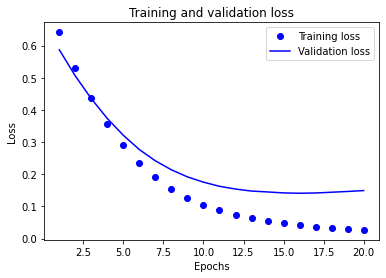

In [19]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [20]:
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.3205293118953705
Test accuracy: 0.883171558380127
